In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas
import seaborn as sns 
from sklearn import preprocessing
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
import re
import string
import matplotlib.cm as cm
from matplotlib import rcParams
from prettytable import PrettyTable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Arabic_tweets_positive dataset

In [2]:
cols = ['class','tweet_text']
positive = pd.read_csv("C:/Users/RSHAF/Desktop/Sentiment Analysis/pos.csv")
positive.head(10)

,class,tweet_text
0,pos,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
1,pos,من الخير نفسه 💛
2,pos,#زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
3,pos,الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...
4,pos,#الاتحاد_النصر لاتحسبونا نسينا يالطواقي ولانبي...
5,pos,احبك انت وياه واموري من سعه 🎶
6,pos,#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫...
7,pos,وينهم الي يرقصوا مع زخات المطر 💃 خلونا نشوفكم ...
8,pos,اللهم آمين يارب العالمين انتي وانا وامة سيدنا ...
9,pos,نمش ننوم ما دا ديل ولادنا 💚


In [3]:
#Count of positve tweets
print(len(positive))

22760


Dataset analysis

In [4]:
#Checking null values count
np.sum(positive.isnull().any(axis=1))

0

In [5]:
positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22760 entries, 0 to 22759
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class       22760 non-null  object
 1   tweet_text  22760 non-null  object
dtypes: object(2)
memory usage: 355.8+ KB


Preprocess data

In [8]:
#cleaning tweet text
for letter in '#.][!XR':
    positive['tweet_text'] = positive['tweet_text'].astype(str).str.replace(letter,'')
#rwmove the punctuations
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [9]:
#normalize_arabic
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [10]:
#remove repeating char
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [11]:
#processPost for applying all functions
def processPost(tweet): 

    #Replace @username with empty string
    tweet = re.sub('@[^\s]+', ' ', tweet)
    
    #Convert www.* or https?://* to " "
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # remove punctuations
    tweet= remove_punctuations(tweet)
    
    # normalize the tweet
    tweet= normalize_arabic(tweet)
    
    # remove repeated letters
    tweet=remove_repeating_char(tweet)
    
    return tweet

In [12]:
# apply used to call the method processpost
positive["tweet_text"] = positive['tweet_text'].apply(lambda x: processPost(x))


Tokenize the tweet text

In [13]:
tokenizer = RegexpTokenizer(r'\w+')
positive["tweet_text"] = positive["tweet_text"].apply(tokenizer.tokenize)

In [14]:
positive["tweet_text"].head(10)

0    [وفي, النهايه, لن, يبقي, معك, احدالا, من, راي,...
1                                    [من, الخير, نفسه]
2    [زلزلالملعبنصرنابيلعب, كن, عالي, الهمه, ولا, ت...
3    [الشيء, الوحيد, الذي, وصلوا, فيه, لعالميه, هو,...
4    [الاتحادالنصر, لاتحسبونا, نسينا, يالطواقي, ولا...
5                   [احبك, انت, وياه, واموري, من, سعه]
6    [تامل, قال, اله, ﷻ, بواد, غير, ذي, زرع, ومع, ذ...
7    [وينهم, الي, يرقصوا, مع, زخات, المطر, خلونا, ن...
8    [الهم, امين, يارب, العالمين, انتي, وانا, وامه,...
9                      [نمش, نوم, ما, دا, ديل, ولادنا]
Name: tweet_text, dtype: object

Removing Stop words

In [15]:
stopwords_list = stopwords.words('arabic')

In [16]:
stopwords_list

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [17]:
print(len(stopwords_list))

754


In [18]:
positive["tweet_text"]=positive["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [19]:
all_words = [word for tokens in positive["tweet_text"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in positive["tweet_text"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

227908 words total, with a vocabulary size of 39102
Max sentence length is 1125


top 10 words in positive

In [20]:
counter = Counter(all_words)

In [21]:
counter.most_common(35)

[('اله', 4542),
 ('علي', 3537),
 ('ان', 1985),
 ('الهم', 1948),
 ('الي', 1536),
 ('الهلال', 1171),
 ('pos', 1118),
 ('الخير', 981),
 ('رتويت', 907),
 ('انا', 870),
 ('الا', 836),
 ('السحب', 811),
 ('يارب', 721),
 ('الحمد', 665),
 ('انت', 653),
 ('سحب', 636),
 ('ساعه', 626),
 ('يوم', 611),
 ('مبروك', 605),
 ('فوز', 593),
 ('الف', 585),
 ('النصر', 577),
 ('واله', 558),
 ('اذا', 511),
 ('بمناسبه', 502),
 ('ال', 489),
 ('قال', 465),
 ('اليوم', 454),
 ('اي', 440),
 ('محمد', 432),
 ('ايفون', 405),
 ('خير', 402),
 ('شي', 394),
 ('تري', 390),
 ('الحياه', 383)]

In [22]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

<BarContainer object of 10 artists>

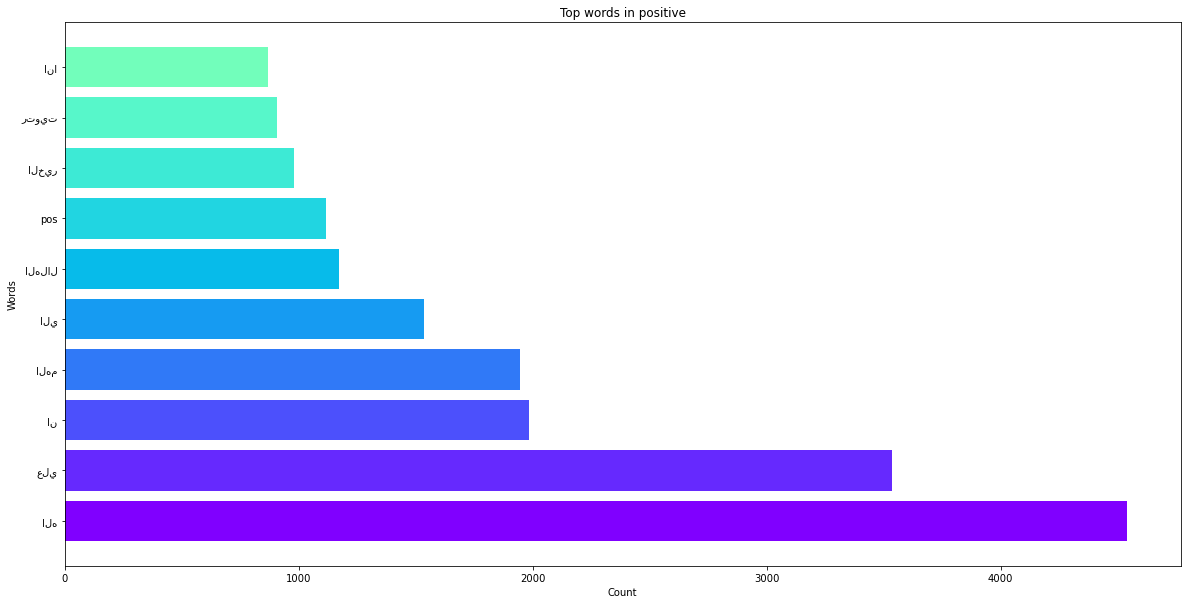

In [23]:
colors = cm.rainbow(np.linspace(0, 1, 20))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in positive')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

Arabic_tweets_negative dataset

In [24]:
cols = ['class','tweet_text']
negative = pd.read_csv("C:/Users/RSHAF/Desktop/Sentiment Analysis/neg.csv")
negative.head(10)

,class,tweet_text
0,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
1,neg,#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...
2,neg,نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...
3,neg,الدودو جايه تكمل علي 💔
4,neg,أحببته حتى أقنعنى إن ما فات من العمر كان إنتظا...
5,neg,يبدو ان دجلة اعتادت على التهام اجساد ابنائها م...
6,neg,جالس أذاكر 😣
7,neg,يكفي استخفاف بالعقل العربي هل حقا الأمن والمخا...
8,neg,ياليلل ترا اكلج كثير مشي 😭
9,neg,لو بيدي أرجع ساعتي وين أرجع؟ إليا صدفه؟ والله ...


In [25]:
negative.head(10)
print(len(negative))

22513


In [26]:
np.sum(negative.isnull().any(axis=1))

0

In [27]:
for letter in '#.][!XR':
    negative['tweet_text'] = negative['tweet_text'].astype(str).str.replace(letter,'')
negative.head(11)

,class,tweet_text
0,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
1,neg,الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال وا...
2,neg,نعمة المضادات الحيوية تضع قطرة💧مضاد بنسلين عل...
3,neg,الدودو جايه تكمل علي 💔
4,neg,أحببته حتى أقنعنى إن ما فات من العمر كان إنتظا...
5,neg,يبدو ان دجلة اعتادت على التهام اجساد ابنائها م...
6,neg,جالس أذاكر 😣
7,neg,يكفي استخفاف بالعقل العربي هل حقا الأمن والمخا...
8,neg,ياليلل ترا اكلج كثير مشي 😭
9,neg,لو بيدي أرجع ساعتي وين أرجع؟ إليا صدفه؟ والله ...


In [28]:
negative["tweet_text"] = negative['tweet_text'].apply(lambda x: processPost(x)) # apply used to call the method processpost



In [29]:
tokenizer = RegexpTokenizer(r'\w+')
negative["tweet_text"] = negative["tweet_text"].apply(tokenizer.tokenize)

negative["tweet_text"].head(11)

0     [توقعت, اذا, جات, داريا, بشوفهم, كاملين, بس, ل...
1     [الاهليالهلال, اكتب, توقعك, لنتيجه, لقاء, الهل...
2     [نعمه, المضادات, الحيويه, تضع, قطره, مضاد, بنس...
3                             [الدودو, جايه, تكمل, علي]
4     [احبته, حتي, اقنعني, ان, ما, فات, من, العمر, ك...
5     [يبدو, ان, دجله, اعتادت, علي, التهام, اجساد, ا...
6                                         [جالس, اذاكر]
7     [يكفي, استخفاف, بالعقل, العربي, هل, حقا, الامن...
8                         [ياليل, ترا, اكلج, كثير, مشي]
9     [لو, بيدي, ارجع, ساعتي, وين, ارجع, اليا, صدفه,...
10                           [ليه, محد, يسوي, معي, كذا]
Name: tweet_text, dtype: object

In [30]:
negative["tweet_text"]=negative["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])



In [31]:
all_words = [word for tokens in negative["tweet_text"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in negative["tweet_text"]]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

208080 words total, with a vocabulary size of 38070
Max sentence length is 884


In [32]:
counter = Counter(all_words)
counter.most_common(35)

[('اله', 2570),
 ('علي', 2110),
 ('الي', 1957),
 ('ان', 1731),
 ('انا', 1611),
 ('واله', 1113),
 ('الهم', 664),
 ('neg', 607),
 ('او', 591),
 ('الناس', 566),
 ('انت', 565),
 ('الا', 554),
 ('مو', 554),
 ('اي', 526),
 ('مش', 498),
 ('شي', 488),
 ('اذا', 482),
 ('يوم', 474),
 ('يارب', 468),
 ('عشان', 467),
 ('يعني', 465),
 ('مافي', 456),
 ('اني', 456),
 ('دي', 436),
 ('حتي', 425),
 ('احد', 422),
 ('اليوم', 373),
 ('الاتحاد', 365),
 ('وانا', 364),
 ('مره', 356),
 ('الهلال', 349),
 ('انه', 343),
 ('الخير', 342),
 ('قلبي', 336),
 ('فض', 335)]

<BarContainer object of 10 artists>

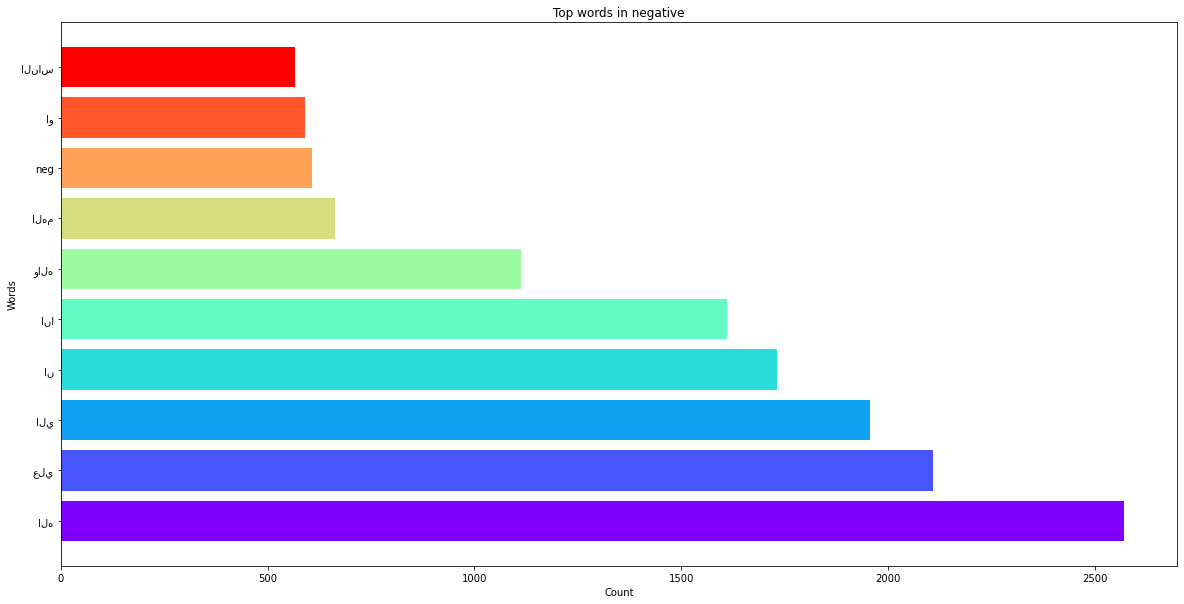

In [33]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in negative')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

Combining the positive and negative

In [34]:
final_data = pd.concat([negative, positive], axis=0)
final_data.head(15)

,class,tweet_text
0,neg,"[توقعت, اذا, جات, داريا, بشوفهم, كاملين, لحين,..."
1,neg,"[الاهليالهلال, اكتب, توقعك, لنتيجه, لقاء, الهل..."
2,neg,"[نعمه, المضادات, الحيويه, تضع, قطره, مضاد, بنس..."
3,neg,"[الدودو, جايه, تكمل, علي]"
4,neg,"[احبته, حتي, اقنعني, ان, فات, العمر, انتظار]"
5,neg,"[يبدو, ان, دجله, اعتادت, علي, التهام, اجساد, ا..."
6,neg,"[جالس, اذاكر]"
7,neg,"[يكفي, استخفاف, بالعقل, العربي, الامن, والمخاب..."
8,neg,"[ياليل, ترا, اكلج, كثير, مشي]"
9,neg,"[بيدي, ارجع, ساعتي, وين, ارجع, اليا, صدفه, وال..."


In [35]:
#total count of final data
print(len(final_data))

45273


In [36]:
#Count of each target class
y=final_data['class']
y.value_counts()

pos    22760
neg    22513
Name: class, dtype: int64

Features Extraction from tweets text with TFIDF unigram

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=10000
)

# Fit the TfidfVectorizer on the data
unigramdataGet = word_vectorizer.fit_transform(final_data['tweet_text'].astype('str'))
unigramdataGet = unigramdataGet.toarray()

vocab = word_vectorizer.get_feature_names_out() 
unigramdata_features = pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
unigramdata_features[unigramdata_features > 0] = 1

unigramdata_features.head()

,10,15,16,1953,250,30,40,412,413,419,...,ڪلما,ڪن,ګنت,گثيرا,ھادي,ۈل,یبقی,یوم,ฬw,ᓄᓚᓅɺ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#encoding class as 1 for Postive class and 0 for negative class
pro= preprocessing.LabelEncoder()
encpro=pro.fit_transform(final_data['class'])
final_data['class'] = encpro




In [40]:
#getting features and Class
y=final_data['class']
X=unigramdata_features
#Spliting Dataset into 70% Training and 30% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=333)

Trainig and Testing with Machine Learning Algorithms
-Naive Bayes Algorithm
-Logistic Regression Algorithm
-Support Vector Machines Algorithm
-MLP Classifier Algorithm
-RandomFores Classifier Algorithm

In [41]:
#Naive Bayes Algorithm
nb=GaussianNB()
nb= nb.fit(X_train , y_train)
nb

GaussianNB()

In [42]:
#Model Evaluation
y_pred = nb.predict(X_test)
nb_1=nb.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(nb.score(X_test, y_test)))
print('Precision',round(f1_score(y_test, y_pred),2),'%')
rf_f1=round(f1_score(y_test, y_pred),2)
print('F1',round(f1_score(y_test, y_pred),2),'%')

Accuracy= 0.720
Precision 0.66 %
F1 0.66 %


In [43]:
#Logistic Regression Algorithm
LR= LogisticRegression(penalty = 'l2', C = 1)
LR= LR.fit(X_train , y_train)
LR

LogisticRegression(C=1)

In [44]:
#Model Evaluation
y_pred = LR.predict(X_test)
lr_1=LR.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(LR.score(X_test, y_test)))


print('Precision',round(f1_score(y_test, y_pred),2),'%')


rf_f1=round(f1_score(y_test, y_pred),2)
print('F1',round(f1_score(y_test, y_pred),2),'%')

Accuracy= 0.769
Precision 0.76 %
F1 0.76 %


In [45]:
#Support Vector Machines Algorithm
from sklearn.svm import SVC
SVCModel = SVC(kernel= 'poly',max_iter=100,C=1.0,gamma='auto')# it can be also linear,poly,sigmoid,precomputed
SVCModel.fit(X_train, y_train)

SVC(gamma='auto', kernel='poly', max_iter=100)

In [46]:
#Model Evaluation
y_pred = SVCModel.predict(X_test)
svm =SVCModel.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(SVCModel.score(X_test, y_test)))

Accuracy= 0.513


In [47]:
#MLP Classifier Algorithm
from sklearn.neural_network import MLPClassifier
MLPClassifierModel = MLPClassifier(activation='relu', # can be also identity , logistic , relu
                                   solver='lbfgs',  # can be also sgd , adam
                                   learning_rate='constant', # can be also invscaling , adaptive
                                   early_stopping= False,max_iter=200,
                                   alpha=0.0001 ,hidden_layer_sizes=(100, 3),random_state=99)
MLPClassifierModel.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 3), random_state=99, solver='lbfgs')

In [48]:
#Model Evaluation
y_pred = MLPClassifierModel.predict(X_test)
nn =MLPClassifierModel.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(MLPClassifierModel.score(X_test, y_test)))

Accuracy= 0.763


In [49]:
#RandomFores Classifier Algorithm
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [50]:
#Model Evaluation
y_pred = clf.predict(X_test)
RF =clf.score(X_test, y_test)
print('Accuracy= {:.3f}'.format(clf.score(X_test, y_test)))

Accuracy= 0.768


In [52]:
#Prediction on sample text using GUI
import tkinter as tk
from tkinter import ttk
import sv_ttk

def process_input():
    input_text = text_input.get("1.0", "end-1c")  # Get input text from the text widget
    if input_text.strip() == "":
        messagebox.showinfo("Error", "Please enter text.")  # Show error message if no text is entered
    else:
        tv = [input_text]  # Create a list with the input text
        x = word_vectorizer.transform(tv)
        pred = LR.predict(x)
        pred = pro.inverse_transform(pred)
        sentiment = pred[0]  # Extract the predicted sentiment
        result_label.config(text=f"The sentiment is: {sentiment}")  # Display the result in the result label

# Create the main window
window = tk.Tk()
window.title("Sentiment Analysis")

# Create the label for the input text
input_label = tk.Label(window, text="Enter text:")
input_label.pack()

# Create the input text widget
text_input = tk.Text(window, height=5, width=30)
text_input.pack()

# Create the button to process the input
process_button = tk.Button(window, text="Analyze Sentiment", command=process_input)
process_button.pack()

# Create the label for the result
result_label = tk.Label(window, text="")
result_label.pack()

# Start the Tkinter event loop
window.mainloop()

